In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, auc, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

In [3]:
df = pd.read_csv("data.csv")

In [4]:
columns_to_use = ["Make",
"Model",
"Year",
"Engine HP",
"Engine Cylinders",
"Transmission Type",
"Vehicle Style",
"highway MPG",
"city mpg",
"MSRP"
]

In [5]:
df_sorted = df[columns_to_use]
df_sorted.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [6]:
df_sorted.columns = df_sorted.columns.str.lower().str.replace(" ", "_")

In [7]:
df_sorted = df_sorted.fillna(0)

In [8]:
average = df_sorted["msrp"].mean()
average

40594.737032063116

In [9]:
df_sorted["msrp"] = (df_sorted["msrp"] > average).astype(int)

In [10]:
df_sorted.msrp.describe()

count    11914.000000
mean         0.274383
std          0.446222
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: msrp, dtype: float64

In [11]:
df_sorted = df_sorted.rename(columns={"msrp":"above_average"})

In [12]:
df_full_train, df_test = train_test_split(df_sorted, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
y_full_train = df_full_train.above_average.values
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [14]:
#del df_full_train["above_average"]
del df_train["above_average"]
del df_val["above_average"]
del df_test["above_average"]

In [15]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [16]:
df_sorted.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
above_average          int64
dtype: object

In [17]:
numeric = df_train.select_dtypes(include='number').columns

In [18]:
df_train.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
5727,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27
5814,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18
8450,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19
2396,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17
5494,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17


In [19]:
numeric = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]

In [20]:
roc_auc_score(y_train, df_train["engine_hp"])

0.9171031265539011

In [21]:
roc_auc_score(y_train, df_train["engine_cylinders"])

0.766116490165669

In [41]:
roc_auc_score(y_train, -df_train["city_mpg"])

0.6723270402704458

In [42]:
roc_auc_score(y_train, -df_train["highway_mpg"])

0.6316523655095094

In [24]:
dv = DictVectorizer(sparse = False)

In [25]:
dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(dicts)

In [26]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [27]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [28]:
dicts = df_val.to_dict(orient="records")
X_val = dv.transform(dicts)

In [29]:
y_val_pred = model.predict_proba(X_val)[:,1]

In [30]:
roc_auc_score(y_val, y_val_pred)


0.9797482414575607

In [31]:
precision = []
recall = []
thresholds = np.linspace(0,1, 100)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
for t in thresholds:
  predict_positive = (y_val_pred >= t)
  predict_negative = (y_val_pred < t)
  tp = (predict_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()
  precision.append(tp / (tp + fp))
  recall.append(tp / (tp + fn))

<ipython-input-31-72fd5c7ba1b6>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision.append(tp / (tp + fp))


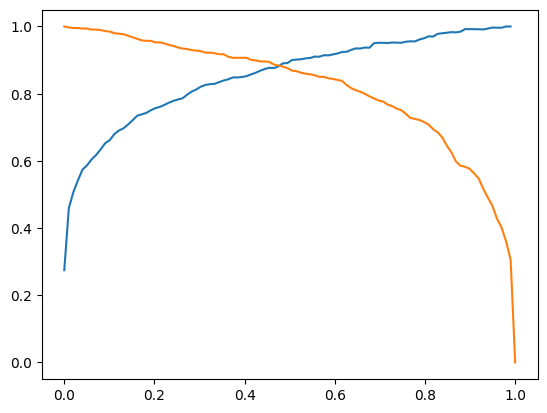

In [32]:
plt.plot(thresholds, precision)
plt.plot(thresholds, recall)

In [33]:
thresholds = [0.12, 0.32, 0.52, 0.72]

for t in thresholds:
  predict_positive = (y_val_pred >= t)
  predict_negative = (y_val_pred < t)
  tp = (predict_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = (2* ((precision * recall) / (precision + recall)))
  print(t, f1)

0.12 0.8085912823752369
0.32 0.8720173535791756
0.52 0.8836846213895394
0.72 0.8494077834179357


In [34]:
columns_to_use = ['make', 'model', 'year', 'engine_hp', 'engine_cylinders', 'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']

In [35]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns_to_use].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

    model.fit(X_train, y_train)

    return dv, model

In [36]:
def predict(df, dv, model):
    dicts = df[columns_to_use].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [37]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [38]:
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]
  y_train = df_train.above_average.values
  y_val = df_val.above_average.values


  dv, model = train(df_train,y_train)

  y_pred = predict(df_val, dv, model)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

In [39]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.979 +- 0.002


In [40]:
for C in [0.01, 0.1, 0.5, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.952 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.977 +- 0.002
C=10 0.981 +- 0.003
